In [1]:
%matplotlib inline
from matplotlib import pylab
import matplotlib.pyplot as plt
import netCDF4 as NC
import numpy as np

import arrow
import datetime
import pandas as pd
from dateutil import tz
from salishsea_tools import tidetools
from salishsea_tools import stormtools_revisions
from salishsea_tools import (nc_tools,viz_tools)

from __future__ import division
import matplotlib.dates as mdates
from datetime import timedelta

In [2]:
fB = NC.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc','r')
lats = fB.variables['nav_lat']
lons = fB.variables['nav_lon']
D = fB.variables['Bathymetry']

#datums from xtide
stations = {'PointAtkinson': 7795, 'Victoria': 7120, 'PatriciaBay': 7277, 'CampbellRiver': 8074}
datums = {'PointAtkinson': 3.09, 'Victoria': 1.881, 'PatriciaBay': 2.256, 'CampbellRiver': 2.916, 
          'CrescentBeach': 2.44, 'WhiteRock': 2.85, 'BoundaryBay': 1 }

In [3]:
#loading files
path = '/ocean/nsoontie/MEOPAR/SalishSea/results/storm-surges/revisions/nov2009/'
runs = {'all_forcing','tidesonly'}
fUs={}; fVs={}; fTs={};
for key in runs:
    fUs[key] = NC.Dataset(path + key +'/SalishSea_4h_20091116_20091122_grid_U.nc','r');
    fVs[key] = NC.Dataset(path + key +'/SalishSea_4h_20091116_20091122_grid_V.nc','r');
    fTs[key] = NC.Dataset(path + key +'/SalishSea_4h_20091116_20091122_grid_T.nc','r');

#preparing data
run_stations={}
us={}; vs={}; lats={}; lons={}; tmps={}; sals={}; sshs={}; ts={};

for run in runs:
    for key in stations:
        string = path + run + '/1h_' + key + '.nc'
        run_stations[key] = NC.Dataset(string,'r');
        tim = run_stations[key].variables['time_counter']
        t_count=np.arange(0, tim.shape[0])
        t=nc_tools.timestamp(run_stations[key],t_count)
        tlist=[]
        for a in t:
           tlist.append(a.datetime) 
        ts[run]=tlist
    [us[run], vs[run], lats[run], lons[run], tmps[run], sals[run], sshs[run]] = stormtools_revisions.combine_data(run_stations)
    run_stations={};


#Observations and tidal predictions
start='31-Dec-2008'; end='02-Jan-2010'
wlev_meas={}; ttide={};
msl = stormtools_revisions.MSLS
for key in stations:
    location=key
    #filename for predictions
    filename='/data/nsoontie/MEOPAR/storm-surge/Revisions/tides/analysis/'+location+'_t_tide_compare8_' +start+'_'+end+'_snr2_filter.csv'
    [ttide[key], _] = stormtools_revisions.load_tidal_predictions(filename)
    
    #filename for obs
    filename = '/data/nsoontie/MEOPAR/storm-surge/Revisions/tides/analysis/wlev_'+str(stations[key])+'_'+start+'_'+end+'.csv'
    wlev_meas[key] = stormtools_revisions.load_observations(filename)
    
#ssh forcing
date_ssh = '01-Nov-2009'
time_ssh={}; ssh_forc={}
[ssh_forc['Tofino'], time_ssh['Tofino']] = stormtools_revisions.get_SSH_forcing('west',date_ssh)
[ssh_forc['Port Hardy'],time_ssh['Port Hardy']] = stormtools_revisions.get_SSH_forcing('north',date_ssh)

CGRF_points={'PointAtkinson': [464,526], 'PatriciaBay': [462, 526], 'Victoria': [461, 526], 'CampbellRiver': [466, 522],
             'Plume': [463, 526]}

#plotting details
wind_ax=[0,25];  ax_ssh=[-1.5,1.5];
x_ax = ['Nov 18, 2009', 'Nov 22, 2009']
start='16-Nov-2009'; end='22-Nov-2009' #for CGRF
start_EC='01-Nov-2009'
end_EC='30-Nov-2009'

unaware=datetime.datetime.strptime(start,"%d-%b-%Y")
sdt = unaware.replace(tzinfo=tz.tzutc())
unaware=datetime.datetime.strptime(end,"%d-%b-%Y")
edt = unaware.replace(tzinfo=tz.tzutc())

In [4]:
def obs_max(data,time,sdt,edt):
  #returns max alue of data and timing of max data (observations) in a give date range (sdt-edt datetime)
  #data can be either anomaly of full water level

#find index of time at start and end
    t=np.array(time); d=np.array(data)
    inds = np.where(t==sdt)[0]
    inde = np.where(t==edt)[0]
    sub_data=np.array(d[inds:inde])
    sub_time = np.array(t[inds:inde])

    max_data = np.nanmax(sub_data)
    time_max =sub_time[np.nanargmax(sub_data)]

    return max_data, time_max

In [5]:
def plot_station(key,axs):
    #plots model ssh, forcing ssh and weather information at the station given by key. 
    hfmt = mdates.DateFormatter('%m/%d')
    print key
    depth=0; 
    #some empty arrays for later
    pres={}; windspeed={}; time={};winddir={}; temp={}

    #retreive CGRF and observed weather
    [windspeed['CGRF'],winddir['CGRF'],pres['CGRF'],time['CGRF']]=stormtools_revisions.get_CGRF_weather(start,end,CGRF_points[key])
    [windspeed['obs'], winddir['obs'],temp['obs'],time['obs'],lat,lon] =stormtools_revisions.get_EC_observations(key, start_EC, end_EC)

    #plotting
    #winds
    ax=axs[0]
    ax.plot(time['obs'],windspeed['obs'],'k-',label='Observations',lw=1.5)
    ax.plot(time['CGRF'],windspeed['CGRF'],'k--',label='Atmospheric Model',lw=1.5)
    ax.legend(loc=1,prop={'size':10})
    ax.set_ylim(wind_ax)
    ax.set_xlim(x_ax)
    ax.set_ylabel('Wind Speed [m/s]')
    ax.grid(True,lw=1)
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(hfmt)
    
    ax=axs[1]    
    ax.plot(time_ssh['Tofino'],ssh_forc['Tofino'][:,0,0],'k-',label='Tofino',lw=1.5)
    ax.plot(time_ssh['Port Hardy'],ssh_forc['Port Hardy'][:,0,0],'k--',label='Port Hardy',lw=1.5)
    ax.set_ylabel('Anomaly Forcing [m]')
    ax.set_xlim(x_ax)
    ax.legend(loc=4,prop={'size':10})
    ax.grid(True,lw=1)
    ax.set_ylim(ax_ssh)
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(hfmt)

    #plot model ssh with observations and tidal predictions
    ax=axs[2]    
    anom_obs=stormtools_revisions.observed_anomaly(ttide[key],wlev_meas[key],msl[key])
    anom_model=sshs['all_forcing'][key][:,0,0]-sshs['tidesonly'][key][:,0,0]
    ax.plot(wlev_meas[key].time, anom_obs, 'k', label='Observations',lw=1.5)
    ax.plot(ts['all_forcing'], anom_model, 'k--',label='Model',lw=1.5)
    ax.set_xlim(x_ax)
    ax.legend(loc=4,prop={'size':10})
    ax.set_ylim(ax_ssh)
    ax.grid(True,lw=1)
    ax.set_ylabel('Residual [m]')
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(hfmt)
    
    [max_wind, time_max]=obs_max(windspeed['obs'],time['obs'],sdt,edt)
    print 'Maximum wind speed: ', max_wind
    print 'Time of maximum wind:', time_max

    
    fig2=plt.figure(figsize=(6,3))
    ax=pylab.subplot(1,1,1)
    fmt = mdates.DateFormatter('%m/%d')
    pylab.plot(time['CGRF'],winddir['CGRF'],'g',label='CGRF')
    pylab.plot(time['obs'],winddir['obs'],'k',label='Observations')
    pylab.title('Wind Direction')
    pylab.ylabel('degrees CCW of East')
    pylab.legend(bbox_to_anchor=(1.05, 1), loc=2)
    ax.set_ylim([0,360])
    ax.set_xlim(x_ax)
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(hfmt)
    pylab.grid()


PointAtkinson
Maximum wind speed:  18.6111111111
Time of maximum wind: 2009-11-19 01:00:00+00:00


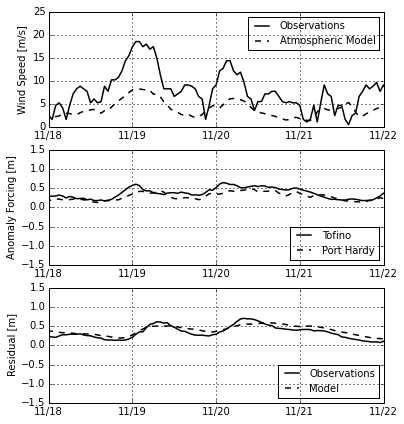

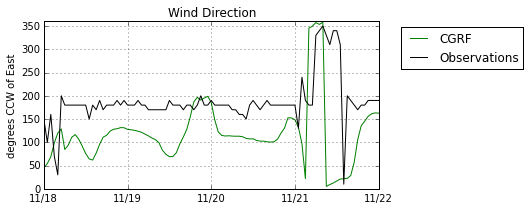

In [9]:
font = {'size'   : 10}

pylab.rc('font', **font)
reload(stormtools_revisions)
(fig,axs)= plt.subplots(3,1,figsize=(6,7))
plot_station('PointAtkinson',axs)
fig.savefig('../RoughWork/Figures/nov2009.pdf',bbox_inches='tight')

# Again for Dec 2006

In [7]:
#loading files
path = '/ocean/nsoontie/MEOPAR/SalishSea/results/storm-surges/final/dec2006/'
runs = {'all_forcing','tidesonly'}
fUs={}; fVs={}; fTs={};
for key in runs:
    fUs[key] = NC.Dataset(path + key +'/SalishSea_4h_20061211_20061217_grid_U.nc','r');
    fVs[key] = NC.Dataset(path + key +'/SalishSea_4h_20061211_20061217_grid_V.nc','r');
    fTs[key] = NC.Dataset(path + key +'/SalishSea_4h_20061211_20061217_grid_T.nc','r');

#preparing data
run_stations={}
us={}; vs={}; lats={}; lons={}; tmps={}; sals={}; sshs={}; ts={};

for run in runs:
    for key in stations:
        string = path + run + '/1h_' + key + '.nc'
        run_stations[key] = NC.Dataset(string,'r');
        tim = run_stations[key].variables['time_counter']
        t_count=np.arange(0, tim.shape[0])
        t=nc_tools.timestamp(run_stations[key],t_count)
        tlist=[]
        for a in t:
           tlist.append(a.datetime) 
        ts[run]=tlist
    [us[run], vs[run], lats[run], lons[run], tmps[run], sals[run], sshs[run]] = stormtools.combine_data(run_stations)
    run_stations={};


#Observations and tidal predictions
start='31-Dec-2005'; end='02-Jan-2007'
wlev_meas={}; ttide={}; msl={}
for key in stations:
    location=key
    #filename for predictions
    filename='/data/nsoontie/MEOPAR/analysis/storm_surges/data/'+location+'_t_tide_compare8_' +start+'_'+end+'.csv'
    [ttide[key], msl[key]] = stormtools.load_tidal_predictions(filename)
    wlev_meas[key] = stormtools.load_observations(start,end,location)
    

#ssh forcing
date_ssh = '01-Dec-2006'
time_ssh={}; ssh_forc={}
[ssh_forc['Tofino'], time_ssh['Tofino']] = stormtools.get_SSH_forcing('west',date_ssh)
[ssh_forc['Port Hardy'],time_ssh['Port Hardy']] = stormtools.get_SSH_forcing('north',date_ssh)

#plotting details
x_ax = ['Dec 13, 2006', 'Dec 18, 2006']
start='11-Dec-2006'; end='18-Dec-2006' #for CGRF
start_EC='01-Dec-2006'
end_EC='31-Dec-2006'

unaware=datetime.datetime.strptime(start,"%d-%b-%Y")
sdt = unaware.replace(tzinfo=tz.tzutc())
unaware=datetime.datetime.strptime(end,"%d-%b-%Y")
edt = unaware.replace(tzinfo=tz.tzutc())

PointAtkinson
Maximum wind speed:  24.1666666667
Time of maximum wind: 2006-12-15 12:00:00+00:00


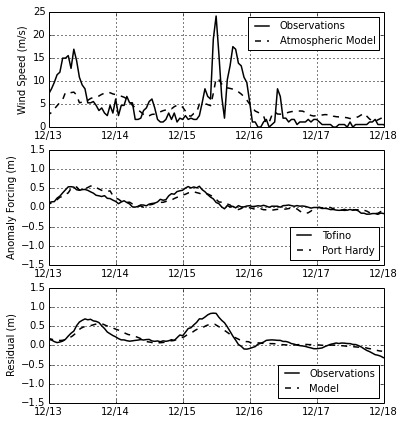

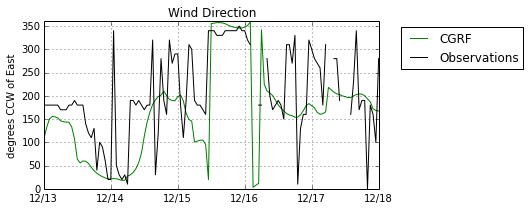

In [8]:
(fig,axs)= plt.subplots(3,1,figsize=(6,7))
plot_station('PointAtkinson',axs)


# Again for Feb 2006

In [9]:
#loading files
path = '/ocean/nsoontie/MEOPAR/SalishSea/results/storm-surges/final/feb2006/'
runs = {'all_forcing','tidesonly'}
fUs={}; fVs={}; fTs={};
for key in runs:
    fUs[key] = NC.Dataset(path + key +'/SalishSea_4h_20060201_20060207_grid_U.nc','r');
    fVs[key] = NC.Dataset(path + key +'/SalishSea_4h_20060201_20060207_grid_V.nc','r');
    fTs[key] = NC.Dataset(path + key +'/SalishSea_4h_20060201_20060207_grid_T.nc','r');

#preparing data
run_stations={}
us={}; vs={}; lats={}; lons={}; tmps={}; sals={}; sshs={}; ts={};

for run in runs:
    for key in stations:
        string = path + run + '/1h_' + key + '.nc'
        run_stations[key] = NC.Dataset(string,'r');
        tim = run_stations[key].variables['time_counter']
        t_count=np.arange(0, tim.shape[0])
        t=nc_tools.timestamp(run_stations[key],t_count)
        tlist=[]
        for a in t:
           tlist.append(a.datetime) 
        ts[run]=tlist
    [us[run], vs[run], lats[run], lons[run], tmps[run], sals[run], sshs[run]] = stormtools.combine_data(run_stations)
    run_stations={};


#Observations and tidal predictions
start='31-Dec-2005'; end='02-Jan-2007'
wlev_meas={}; ttide={}; msl={}
for key in stations:
    location=key
    #filename for predictions
    filename='/data/nsoontie/MEOPAR/analysis/storm_surges/data/'+location+'_t_tide_compare8_' +start+'_'+end+'.csv'
    [ttide[key], msl[key]] = stormtools.load_tidal_predictions(filename)
    wlev_meas[key] = stormtools.load_observations(start,end,location)
    

#ssh forcing
date_ssh = '01-Feb-2006'
time_ssh={}; ssh_forc={}
[ssh_forc['Tofino'], time_ssh['Tofino']] = stormtools.get_SSH_forcing('west',date_ssh)
[ssh_forc['Port Hardy'],time_ssh['Port Hardy']] = stormtools.get_SSH_forcing('north',date_ssh)

#plotting details
x_ax = ['Feb 1, 2006', 'Feb 7, 2006']
start='2-Feb-2006'; end='7-Feb-2006' #for CGRF
start_EC='01-Feb-2006'
end_EC='28-Feb-2006'

unaware=datetime.datetime.strptime(start,"%d-%b-%Y")
sdt = unaware.replace(tzinfo=tz.tzutc())
unaware=datetime.datetime.strptime(end,"%d-%b-%Y")
edt = unaware.replace(tzinfo=tz.tzutc())

PointAtkinson
Maximum wind speed:  18.0555555556
Time of maximum wind: 2006-02-04 13:00:00+00:00


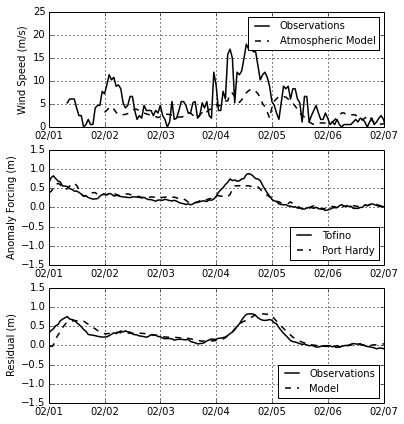

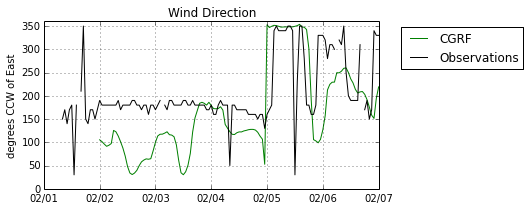

In [10]:
(fig,axs)= plt.subplots(3,1,figsize=(6,7))
plot_station('PointAtkinson',axs)

# Again for Nov 2006

In [11]:
#loading files
path = '/ocean/nsoontie/MEOPAR/SalishSea/results/storm-surges/final/nov2006/'
runs = {'all_forcing','tidesonly'}
fUs={}; fVs={}; fTs={};
for key in runs:
    fUs[key] = NC.Dataset(path + key +'/SalishSea_4h_20061112_20061118_grid_U.nc','r');
    fVs[key] = NC.Dataset(path + key +'/SalishSea_4h_20061112_20061118_grid_V.nc','r');
    fTs[key] = NC.Dataset(path + key +'/SalishSea_4h_20061112_20061118_grid_T.nc','r');

#preparing data
run_stations={}
us={}; vs={}; lats={}; lons={}; tmps={}; sals={}; sshs={}; ts={};

for run in runs:
    for key in stations:
        string = path + run + '/1h_' + key + '.nc'
        run_stations[key] = NC.Dataset(string,'r');
        tim = run_stations[key].variables['time_counter']
        t_count=np.arange(0, tim.shape[0])
        t=nc_tools.timestamp(run_stations[key],t_count)
        tlist=[]
        for a in t:
           tlist.append(a.datetime) 
        ts[run]=tlist
    [us[run], vs[run], lats[run], lons[run], tmps[run], sals[run], sshs[run]] = stormtools.combine_data(run_stations)
    run_stations={};


#Observations and tidal predictions
start='31-Dec-2005'; end='02-Jan-2007'
wlev_meas={}; ttide={}; msl={}
for key in stations:
    location=key
    #filename for predictions
    filename='/data/nsoontie/MEOPAR/analysis/storm_surges/data/'+location+'_t_tide_compare8_' +start+'_'+end+'.csv'
    [ttide[key], msl[key]] = stormtools.load_tidal_predictions(filename)
    wlev_meas[key] = stormtools.load_observations(start,end,location)
    

#ssh forcing
date_ssh = '01-Nov-2006'
time_ssh={}; ssh_forc={}
[ssh_forc['Tofino'], time_ssh['Tofino']] = stormtools.get_SSH_forcing('west',date_ssh)
[ssh_forc['Port Hardy'],time_ssh['Port Hardy']] = stormtools.get_SSH_forcing('north',date_ssh)

#plotting details
x_ax = ['Nov 12, 2006', 'Nov 19, 2006']
start='11-Nov-2006'; end='19-Nov-2006' #for CGRF
start_EC='01-Nov-2006'
end_EC='30-Nov-2006'

unaware=datetime.datetime.strptime(start,"%d-%b-%Y")
sdt = unaware.replace(tzinfo=tz.tzutc())
unaware=datetime.datetime.strptime(end,"%d-%b-%Y")
edt = unaware.replace(tzinfo=tz.tzutc())

PointAtkinson
Maximum wind speed:  20.0
Time of maximum wind: 2006-11-15 17:00:00+00:00


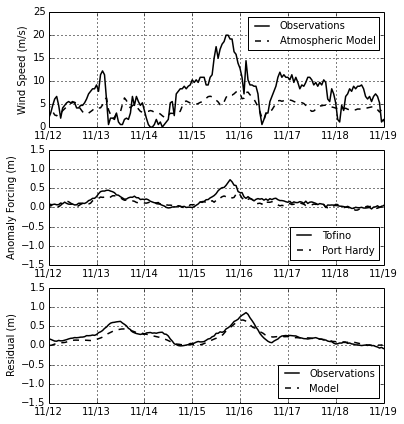

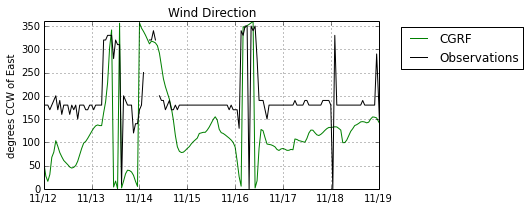

In [12]:
(fig,axs)= plt.subplots(3,1,figsize=(6,7))
plot_station('PointAtkinson',axs)

# Dec 2012

In [13]:
#loading files
path = '/ocean/nsoontie/MEOPAR/SalishSea/results/storm-surges/final/dec2012/'
runs = {'CGRF/all_forcing','tidesonly'}
fUs={}; fVs={}; fTs={};
for key in runs:
    fUs[key] = NC.Dataset(path + key +'/SalishSea_4h_20121214_20121218_grid_U.nc','r');
    fVs[key] = NC.Dataset(path + key +'/SalishSea_4h_20121214_20121218_grid_V.nc','r');
    fTs[key] = NC.Dataset(path + key +'/SalishSea_4h_20121214_20121218_grid_T.nc','r');
#preparing data
run_stations={}
us={}; vs={}; lats={}; lons={}; tmps={}; sals={}; sshs={}; ts={};
#fUs['all_forcing'] = fUs['CGRF/all_forcing']
#fVs['all_forcing'] = fVs['CGRF/all_forcing']
#fTs['all_forcing'] = fTs['CGRF/all_forcing']
#runs = {'all_forcing','tidesonly'}

for run in runs:
    for key in stations:
        string = path + run + '/1h_' + key + '.nc'
        run_stations[key] = NC.Dataset(string,'r');
        tim = run_stations[key].variables['time_counter']
        t_count=np.arange(0, tim.shape[0])
        t=nc_tools.timestamp(run_stations[key],t_count)
        tlist=[]
        for a in t:
           tlist.append(a.datetime) 
        ts[run]=tlist
    [us[run], vs[run], lats[run], lons[run], tmps[run], sals[run], sshs[run]] = stormtools.combine_data(run_stations)
    run_stations={};

sshs['all_forcing']=sshs['CGRF/all_forcing']
ts['all_forcing']=ts['CGRF/all_forcing']

#Observations and tidal predictions
start='31-Dec-2011'; end='02-Jan-2013'
wlev_meas={}; ttide={}; msl={}
for key in stations:
    location=key
    #filename for predictions
    filename='/data/nsoontie/MEOPAR/analysis/storm_surges/data/'+location+'_t_tide_compare8_' +start+'_'+end+'.csv'
    [ttide[key], msl[key]] = stormtools.load_tidal_predictions(filename)
    wlev_meas[key] = stormtools.load_observations(start,end,location)
    

#ssh forcing
date_ssh = '01-Dec-2012'
time_ssh={}; ssh_forc={}
[ssh_forc['Tofino'], time_ssh['Tofino']] = stormtools.get_SSH_forcing('west',date_ssh)
[ssh_forc['Port Hardy'],time_ssh['Port Hardy']] = stormtools.get_SSH_forcing('north',date_ssh)

#plotting details
x_ax = ['Dec 13, 2012', 'Dec 19, 2012']
start='11-Dec-2012'; end='18-Dec-2012' #for CGRF
start_EC='01-Dec-2012'
end_EC='31-Dec-2012'

unaware=datetime.datetime.strptime(start,"%d-%b-%Y")
sdt = unaware.replace(tzinfo=tz.tzutc())
unaware=datetime.datetime.strptime(end,"%d-%b-%Y")
edt = unaware.replace(tzinfo=tz.tzutc())

PointAtkinson
Maximum wind speed:  15.5555555556
Time of maximum wind: 2012-12-15 18:00:00+00:00


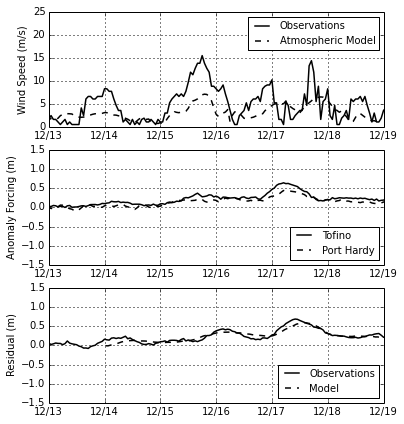

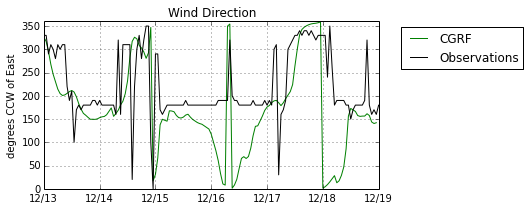

In [14]:
(fig,axs)= plt.subplots(3,1,figsize=(6,7))
plot_station('PointAtkinson',axs)